# NB 1 - Developing Metrics

Based on [The MVTec Anomaly Detection Dataset: A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection](https://link.springer.com/article/10.1007/s11263-020-01400-4)
> Bergmann, P., Batzner, K., Fauser, M. et al. The MVTec Anomaly Detection Dataset: A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection. Int J Comput Vis 129, 1038–1059 (2021). https://doi.org/10.1007/s11263-020-01400-4


In [1]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import matplotlib.pyplot as plt
import torch
import torchvision

# custom packages
import src.commons.dataset as ds
import src.commons.constants as cons

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

## Data
Use some test data to build the method

In [2]:
cat = "capsule"

test_dataset = ds.MVTECTestDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), cat)

print(len(test_dataset), len(test_dataset.test_data), len(test_dataset.ground_truth))

132 132 132


In [3]:
for sample in test_dataset:
    if ('011' in sample['class_and_id']) and ('crack' in sample['class_and_id']):
        img1, mask1, ex_name1 = sample["test"], sample["ground_truth"], sample['class_and_id']
    elif ('010' in sample['class_and_id']) and ('crack' in sample['class_and_id']):
        img2, mask2, ex_name2 = sample["test"], sample["ground_truth"], sample['class_and_id']

In [4]:
def show_img_and_mask(img, mask, ex_name):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    ax1.imshow(torch.permute(img, (1, 2, 0)))
    ax1.set_title('Raw image')
    ax2.imshow(torch.permute(img, (1, 2, 0)))
    ax2.imshow(torch.permute(mask, (1, 2, 0)), cmap="spring", alpha=0.5, vmax=mask.max()/2)
    ax2.set_title('Ground truth mask')
    fig.suptitle(ex_name)
    plt.show()

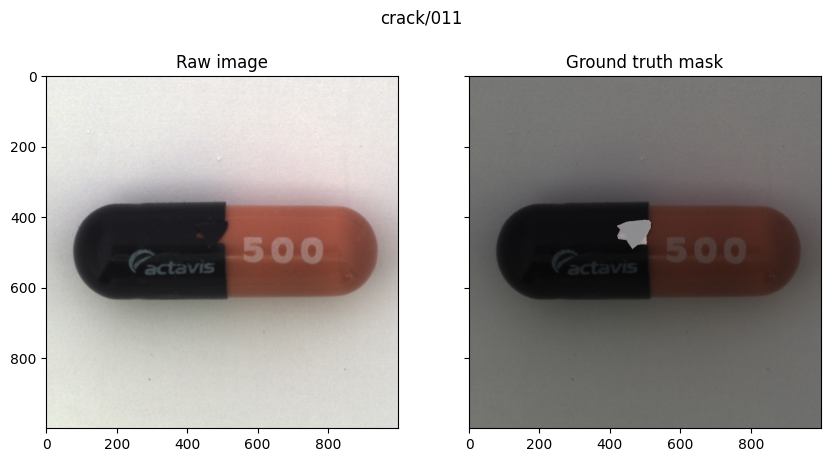

In [5]:
show_img_and_mask(img1, mask1, ex_name1)

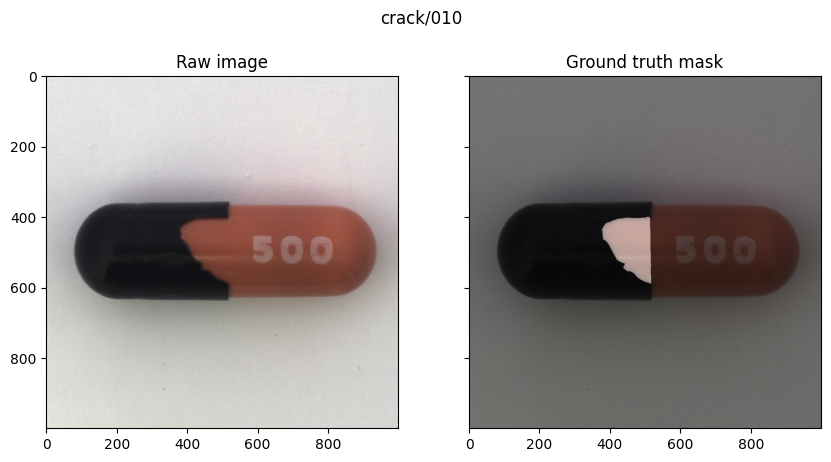

In [6]:
show_img_and_mask(img2, mask2, ex_name2)

Let's assume `mask1` is the real mask and `mask2` is the predicted mask

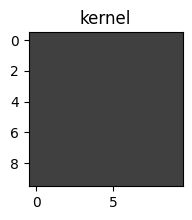

In [7]:
import numpy as np

k = 10
mean_kernel = np.full((k, k), 1/4)

plt.figure(figsize=(2,2))
plt.imshow(mean_kernel, cmap="gray", vmin=0, vmax=1)
plt.title('kernel')
plt.show()

In [8]:
import scipy.signal as signal


mask2_gray = torchvision.transforms.functional.rgb_to_grayscale(mask2)
mask2_gray2D = torch.permute(mask2_gray, (1, 2, 0))[:, :, -1]

mask1_gray = torchvision.transforms.functional.rgb_to_grayscale(mask1)
mask1_gray2D = torch.permute(mask1_gray, (1, 2, 0))[:, :, -1]

# filter second mask 
mask2_mean = signal.convolve2d(mask2_gray2D, mean_kernel, mode='full')
m_min = mask2_mean.min()
m_max = mask2_mean.max()
mask2_mean = (mask2_mean - m_min) / (m_max-m_min)
mask2_mean = mask2_mean[0: mask2_gray2D.shape[0], 0: mask2_gray2D.shape[1]]

mask2_mean = torch.tensor(mask2_mean)

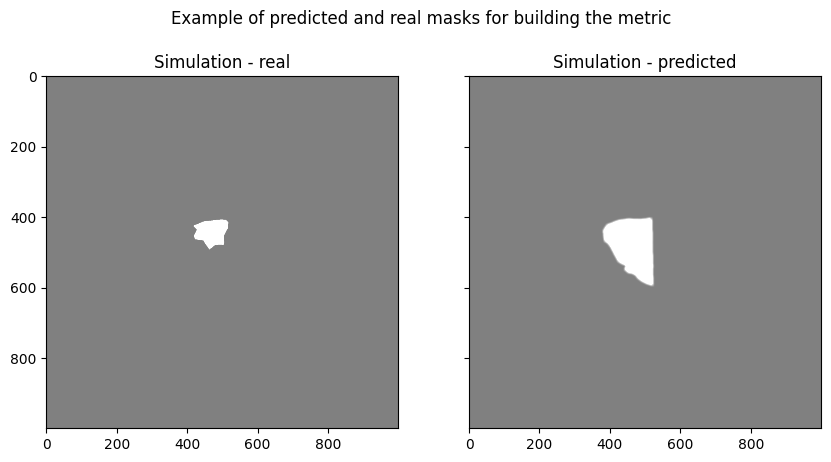

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax1.imshow(mask1_gray2D, cmap="gray", alpha=0.5, vmax=mask1_gray2D.max()/2)
ax1.set_title('Simulation - real')
ax2.imshow(mask2_mean, cmap="gray", alpha=0.5, vmax=mask2_mean.max()/2)
ax2.set_title('Simulation - predicted')
fig.suptitle('Example of predicted and real masks for building the metric')
plt.show()

# Metrics

## Pixel-Level Metrics

**1st metrics**:
- $TP = \sum_{i=1}^{n}{|\{p | G_i (p) = 1\} \cap \{p | A_i(p) > t\}|} $

- $FP = \sum_{i=1}^{n}{|\{p | G_i (p) = 0\} \cap \{p | A_i(p) > t\}|} $

- $TN = \sum_{i=1}^{n}{|\{p | G_i (p) = 1\} \cap \{p | A_i(p) <= t\}|} $

- $FN = \sum_{i=1}^{n}{|\{p | G_i (p) = 1\} \cap \{p | A_i(p) <= t\}|} $

In [10]:
def get_pred_mask(preds: torch.Tensor, threshold: float) -> torch.Tensor:
    """
    preds: torch.Size([1000, 1000]), torch.float64, [0, 1]
    """
    return preds > threshold


def get_real_mask(mask: torch.Tensor) -> torch.Tensor:
    """
    mask: torch.Size([1000, 1000]), torch.uint8, [0, 255]
    """
    return mask > int(255/2)

In [88]:
real_mask = get_real_mask(mask1_gray2D)
pred_mask = get_pred_mask(mask2_mean, 0.99)

In [89]:
def get_tp(pred_mask: torch.Tensor, real_mask:torch.Tensor) -> torch.Tensor:
    """
    pred_mask: torch.Size([1000, 1000]), torch.bool, [True, False]
    real_mask: torch.Size([1000, 1000]), torch.bool, [True, False]
    """
    return np.logical_and(pred_mask, real_mask)


def get_tn(pred_mask: torch.Tensor, real_mask:torch.Tensor) -> torch.Tensor:
    """
    pred_mask: torch.Size([1000, 1000]), torch.bool, [True, False]
    real_mask: torch.Size([1000, 1000]), torch.bool, [True, False]
    """
    return np.logical_and(~pred_mask, ~real_mask)

def get_xor_mask(pred_mask: torch.Tensor, real_mask:torch.Tensor) -> torch.Tensor:
    """
    pred_mask: torch.Size([1000, 1000]), torch.bool, [True, False]
    real_mask: torch.Size([1000, 1000]), torch.bool, [True, False]
    """
    return np.logical_xor(pred_mask, real_mask)

def get_fp(pred_mask: torch.Tensor, xor_mask:torch.Tensor):
    """
    pred_mask: torch.Size([1000, 1000]), torch.bool, [True, False]
    xor_mask: torch.Size([1000, 1000]), torch.uint8, [0, 1]
    """
    return np.logical_and(pred_mask, xor_mask)

def get_fn(real_mask: torch.Tensor, xor_mask:torch.Tensor):
    """
    real_mask: torch.Size([1000, 1000]), torch.bool, [True, False]
    xor_mask: torch.Size([1000, 1000]), torch.uint8, [0, 1]
    """
    return np.logical_and(real_mask, xor_mask)

In [90]:
mask_tp = get_tp(pred_mask, real_mask)
mask_tn = get_tn(pred_mask, real_mask)

# temporary mask for building the incorrect predictions
mask_xor = get_xor_mask(pred_mask, real_mask)
mask_fp = get_fp(pred_mask, mask_xor)
mask_fn = get_fn(real_mask, mask_xor)

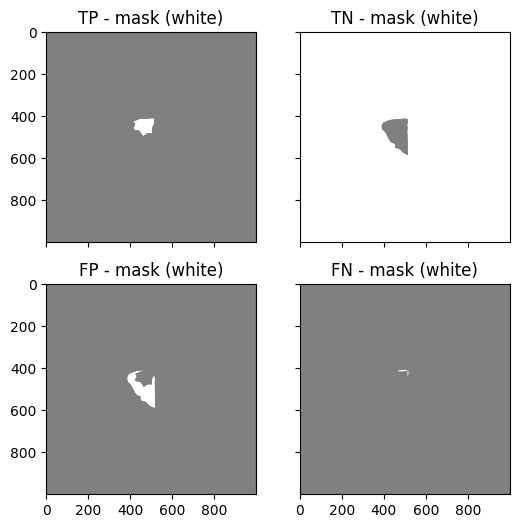

In [91]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True, sharey=True)
ax1.imshow(mask_tp, cmap="gray", alpha=0.5, vmax=mask_tp.max()/2)
ax1.set_title('TP - mask (white)')
ax2.imshow(mask_tn, cmap="gray", alpha=0.5, vmax=mask_tn.max()/2)
ax2.set_title('TN - mask (white)')
ax3.imshow(mask_fp, cmap="gray", alpha=0.5, vmax=mask_fp.max()/2)
ax3.set_title('FP - mask (white)')
ax4.imshow(mask_fn, cmap="gray", alpha=0.5, vmax=mask_fn.max()/2)
ax4.set_title('FN - mask (white)')
plt.show()

In [92]:
# Sum all pixels
TP = mask_tp.sum().numpy()
TN = mask_tn.sum().numpy()
FP = mask_fp.sum().numpy()
FN = mask_fn.sum().numpy()

**2nd metrics**:
- $FPR = \frac{FP}{FP + TN}$

- $PRC = \frac{TP}{TP + FP}$

- $IoU = \frac{P \cap G}{P \cup G} = \frac{TP}{TP + FP + FN}$

In [93]:
def get_fpr(fp, tn):
    if fp == 0:
        return 0
    elif fp + tn == 0:
        return None
    else: 
        return fp / (fp + tn)

def get_prc(tp, fp):
    if tp == 0:
        return 0
    elif fp + tp == 0:
        return None
    else: 
        return tp / (fp + tp)

def get_intersection_over_union(tp, fp, fn):
    if tp == 0:
        return 0
    elif fp + tp + fn == 0:
        return None
    else: 
        return tp / (fp + tp + fn)
    

In [94]:
fpr = get_fpr(fp=FP, tn=TN)
prc = get_prc(tp=TP, fp=FP)
iou = get_intersection_over_union(tp=TP, fp=FP, fn=FN)

In [95]:
print(f"FPR: {fpr:.4f}")
print(f"PRC: {prc:.4f}")
print(f"IoU: {iou:.4f}")

FPR: 0.0098
PRC: 0.3496
IoU: 0.3457


## Region-Level Metrics

$PRO = \frac{1}{N} \sum_{i} \sum_{k} \frac{|P_i \cap C_{i,k}|}{|C_{i,k}|}$

In [114]:
import skimage


def get_connected_regions(x_mask: torch.Tensor):
    conn_label = skimage.measure.label(x_mask, background=False, connectivity=2)
    return conn_label


In [115]:
pred_conn_components = get_connected_regions(pred_mask)
real_conn_components = get_connected_regions(real_mask)
union_components = np.logical_and(pred_conn_components, real_conn_components)


In [116]:
max_regions = max(pred_conn_components.max(), real_conn_components.max())
print(f"There are a maximum of {max_regions} connected components between predictions and real masks")

There are a maximum of 1 connected components between predictions and real masks


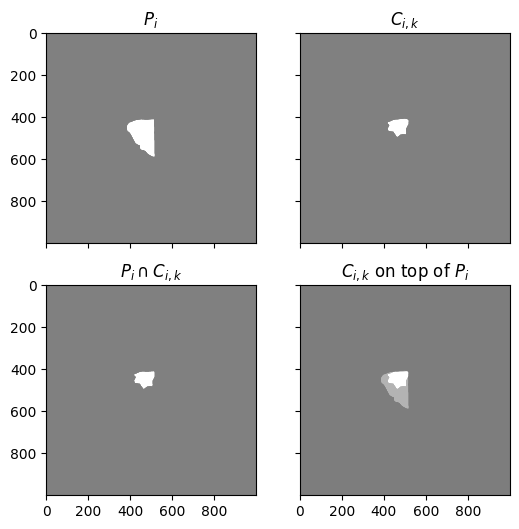

In [117]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True, sharey=True)
ax1.imshow(pred_conn_components, cmap="gray", alpha=0.5, vmax=pred_conn_components.max()/2)
ax1.set_title('$P_i$')
ax2.imshow(real_conn_components, cmap="gray", alpha=0.5, vmax=real_conn_components.max()/2)
ax2.set_title('$C_{i,k}$')
ax3.imshow(union_components, cmap="gray", alpha=0.5, vmax=union_components.max()/2)
ax3.set_title('$P_i \cap C_{i,k}$')

ax4.imshow(pred_conn_components, cmap="gray", alpha=0.3, vmax=pred_conn_components.max()/2)
ax4.imshow(real_conn_components, cmap="gray", alpha=0.3, vmax=real_conn_components.max()/2)
ax4.set_title('$C_{i,k}$ on top of $P_i$')
plt.show()

In [119]:
real_conn_components.max()

1

In [146]:
pro = 0
# for all connected components 
for conn in range(real_conn_components.max()):
    conn_label = conn + 1 # python starts in index 0
    c_ik_conn_mask = np.where(real_conn_components == conn_label, True, False)
    c_ik_conn_area = len(c_ik_conn_mask[c_ik_conn_mask == True])
    print(f"C_i,k$: {c_ik_conn_area}")
    
    union_components_conn = np.logical_and(pred_conn_components, c_ik_conn_mask)
    p_i_c_ik_conn_area = len(union_components_conn[union_components_conn == True])
    print(f"P_i AND C_i,k$: {p_i_c_ik_conn_area}")
    
    pro += p_i_c_ik_conn_area/c_ik_conn_area

pro = pro / (real_conn_components.max())
print(f"PRO: {pro:.4f}")


C_i,k$: 5428
P_i AND C_i,k$: 5258
PRO: 0.9687


## Threshold Independent metrics